## Задание

https://www.kaggle.com/competitions/urfu-engai-2023-competition-3

Инструкции  
Подробная инструкция в прошлых семестрах. Вы уже взрослые  

Вкратце:  
Проходим по ссылке Cоревнования.  Принять участие, да, далее согласен. И т.д.  
Ладно, как загружать будет блокнот  
Обучаем модель  
- грузим тренировочные данные   
- выполняем предварительный анализ  
- убираем мусорные признаки   
- обучаем модель на ваш выбор  
- работаем с признаками, крутим гиперпараметры  
- оцениваем точность модели  

Применяем модель к тестовым данным  
Загружаем данные на платформу. 
Если метрика на платформе - норм, загружаем решение сюда. Если нет - повторяем пункты 3-5.  


Оцениваться будет не только итоговая метрика на платформе, но и качество оформления решения (критерии оценки приложены в задании)  
Дедлайн - до конца года, мы никуда не спешим, но и не сильно тормозим.

### UrFU EngAI 2023 Competition 3 
(Поиск полезной информации в мусоре)

**Description**  

*Предсказание цены*  
В этом семестре вам предстоит опять предсказывать цену чего-то (только не известно чего). Это секрет
Дело в том что для одного из датасетов, найденных на просторах Kaggle я выполнил следующие действия

- Добавил много "мусорных" признаков
- Перевел категориальные признаки в числовые (благо они хранятся как int)
- Перемешал порядок колонок


Поэтому перед тем как делать fit_predict вам придется сделать анализ данных и найти мусорные признаки

Спасибо команде курса https://stepik.org/course/108888/promo за шикарную идею (НЕ РЕКЛАМА)

**Evaluation**  

В качестве метрики выбран Коэффициент Детерминации (r2 score)

**Целевая метрика**  
r2 => 0.9

**Files**  

- Train.csv - тренировочный набор
- Test.csv - тестовый набор
- Target.csv - правильные ответы для тренировочного набора
- submission.csv - пример файла загрузки с константным предсказанием

### Функции

Оптимизация объема памяти, занимаемого датасетом

In [1]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances)))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Import библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [4]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [6]:
import warnings 
warnings.simplefilter("ignore", UserWarning)

### Считываем файлы в DataFrame

In [7]:
target = pd.read_csv('./Data/3semestr/Regresion/target.csv')
train = pd.read_csv('./Data/3semestr/Regresion/train.csv')
test = pd.read_csv('./Data/3semestr/Regresion/test.csv')
submission_reg = pd.read_csv('./Data/3semestr/Regresion/submission.csv')

### Первичный анализ данных

**Посмотрим на тренировочный датасет**

In [8]:
train.head()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 110,feature 111,feature 112,feature 113,feature 114,feature 115,feature 116,feature 117,feature 118,feature 119
0,83485,192,-0.793055,2.146826,69065,-1.669705,50125,28150,2015,4,...,-1.848419,92262,2.410047,-2.634328,82117,-3.890304,68867,48164,51872,11
1,61327,349,1.104836,5.225879,36752,-1.733360,79442,68217,2017,11,...,-0.819262,86257,-0.241159,-3.974434,100267,0.398294,81463,76968,97572,6
2,11507,-1,-0.576450,-0.216464,26222,5.303614,94105,60036,2015,15,...,-0.037468,29364,1.667534,3.808748,17868,-1.129200,16708,81893,86716,5
3,21702,-1,0.950735,6.027220,16806,-5.240428,41475,43285,2015,1,...,0.421387,103000,-0.767304,2.483723,662,-0.547571,33735,20083,2596,2
4,102575,295,1.002829,3.167539,18750,-3.269408,31965,58322,2000,14,...,-0.171998,102439,-0.281879,-1.991910,49932,2.693124,26524,21624,51450,5


In [9]:
train.shape

(82548, 121)

In [10]:
train.describe()

,ID,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 110,feature 111,feature 112,feature 113,feature 114,feature 115,feature 116,feature 117,feature 118,feature 119
count,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,...,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000,82548.000000
mean,59077.929168,126.370209,0.000419,0.015101,53206.432185,0.000673,55026.348428,52360.881305,2012.936800,11.421791,...,0.005649,53168.458230,-0.005272,-0.007029,50901.596065,-0.004071,54365.502483,52940.970805,50899.550649,12.085780
std,34100.042938,116.980277,1.001054,4.006067,30646.394191,3.002641,31688.068806,30263.664042,5.687987,7.080628,...,0.999099,30768.809004,1.001487,4.006605,29385.422661,1.999163,31274.978432,30685.547694,29351.418453,7.001836
min,1.000000,-1.000000,-4.143062,-15.698991,0.000000,-12.866035,0.000000,0.000000,1964.000000,0.000000,...,-4.160585,1.000000,-4.573165,-17.154796,0.000000,-9.089964,1.000000,0.000000,0.000000,0.000000
25%,29454.500000,-1.000000,-0.676218,-2.670942,26663.000000,-2.029110,27534.750000,26109.000000,2009.000000,5.000000,...,-0.665559,26519.250000,-0.682815,-2.692385,25533.000000,-1.344816,27297.000000,26329.000000,25558.750000,6.000000
50%,59202.500000,97.000000,0.003073,0.012229,53091.000000,0.002497,55162.000000,52494.000000,2013.000000,11.000000,...,0.008502,52986.500000,-0.003280,-0.007747,50692.500000,-0.013693,54371.500000,53019.000000,50969.000000,12.000000
75%,88692.750000,233.000000,0.673262,2.738888,79826.000000,2.024756,82467.250000,78507.000000,2018.000000,17.000000,...,0.678705,79919.500000,0.667496,2.691176,76493.000000,1.343239,81302.000000,79507.250000,76296.500000,19.000000
max,117925.000000,363.000000,4.278363,17.101731,106154.000000,12.984362,109739.000000,104810.000000,2022.000000,22.000000,...,4.196688,106425.000000,4.374344,17.133610,101787.000000,8.647349,108465.000000,106088.000000,101791.000000,22.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82548 entries, 0 to 82547
Columns: 121 entries, ID to feature 119
dtypes: float64(50), int64(71)
memory usage: 76.2 MB


Процентный список пропущенных данных

In [12]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    if pct_missing !=0:
        print('{} - {}%'.format(col, round(pct_missing*100)))
print('Больше пропущенных значений нет!')

Больше пропущенных значений нет!


Составим список признаков, у которых более 95% строк содержат одно и то же значение

In [13]:
trashhold = 0.95

In [14]:
num_rows = len(train.index)
low_information_cols = [] #

for col in train.columns:
    cnts = train[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > trashhold:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

feature 19: 100.00000%
feature 19
5    82548
Name: count, dtype: int64

feature 20: 100.00000%
feature 20
2    82548
Name: count, dtype: int64

feature 27: 100.00000%
feature 27
8    82548
Name: count, dtype: int64

feature 50: 100.00000%
feature 50
3    82548
Name: count, dtype: int64

feature 51: 100.00000%
feature 51
7    82548
Name: count, dtype: int64

feature 56: 100.00000%
feature 56
5    82548
Name: count, dtype: int64

feature 60: 100.00000%
feature 60
6    82548
Name: count, dtype: int64

feature 70: 100.00000%
feature 70
9    82548
Name: count, dtype: int64

feature 78: 100.00000%
feature 78
7    82548
Name: count, dtype: int64

feature 96: 100.00000%
feature 96
1    82548
Name: count, dtype: int64



Удалим эти признаки

In [15]:
train = train.drop(low_information_cols, axis=1)

Построим тепловую карту корреляции признаков

In [16]:
sns.heatmap(train.corr())

<Axes: >

In [17]:
trashhold = 0.8

In [18]:
corr_cols = [] #

for col in train.columns:
    for col_2 in train.columns:
        if (col != col_2) and ((train[col].corr(train[col_2]) >= trashhold or train[col].corr(train[col_2]) <= -trashhold)):
            corr_cols.append(col)
            print(f'{col} - {col_2}: {train[col].corr(train[col_2])}')
            print()

feature 7 - feature 83: -1.0

feature 83 - feature 7: -1.0



Удалим лишние признаки

In [19]:
#corr_cols = list(set(corr_cols))

In [20]:
#df = train[['feature 7', 'feature 31', 'feature 83']]
#df.head()

In [21]:
train = train.drop(['feature 83'], axis=1)

Посмотрим количество уникальных значений в столбце  
Выберем категориальные фичи
Выберем числовые значения

In [22]:
train = train.drop(['ID'], axis=1)

In [23]:
cat_col = []
num_col = []
for col in train.columns:
    if train[col].nunique() <= 51:
        cat_col.append(col)
    else:
        num_col.append(col)
    print(f'Столбец "{col}": количество уникальных значений {train[col].nunique()}')

Столбец "feature 0": количество уникальных значений 365
Столбец "feature 1": количество уникальных значений 82548
Столбец "feature 2": количество уникальных значений 82548
Столбец "feature 3": количество уникальных значений 57445
Столбец "feature 4": количество уникальных значений 82548
Столбец "feature 5": количество уникальных значений 58053
Столбец "feature 6": количество уникальных значений 57031
Столбец "feature 7": количество уникальных значений 51
Столбец "feature 8": количество уникальных значений 23
Столбец "feature 9": количество уникальных значений 82548
Столбец "feature 10": количество уникальных значений 56367
Столбец "feature 11": количество уникальных значений 57487
Столбец "feature 12": количество уникальных значений 57841
Столбец "feature 13": количество уникальных значений 82548
Столбец "feature 14": количество уникальных значений 82548
Столбец "feature 15": количество уникальных значений 57973
Столбец "feature 16": количество уникальных значений 56984
Столбец "featur

Фичи с количеством <=51 - категориальные, пример ниже:

In [24]:
train["feature 7"].unique()

array([2015, 2017, 2000, 2021, 2011, 2010, 2012, 2007, 2003, 2020, 2001,
       2016, 2014, 2018, 1997, 2008, 2019, 2013, 2009, 2004, 2022, 2006,
       2002, 1998, 1993, 2005, 1999, 1970, 1996, 1990, 1994, 1995, 1991,
       1992, 1981, 1968, 1988, 1987, 1967, 1973, 1989, 1971, 1964, 1966,
       1972, 1978, 1983, 1974, 1985, 1965, 1986], dtype=int64)

Посмотрим на значение дисперсии признаков, удали те, где дисперсия незначительная как малозначимые (меньше 10)

In [25]:
lowvar_col = []
for col in num_col:
    if train[col].var(ddof=0) <= 10:
        lowvar_col.append(col)
        print(f'Столбец "{col}": значение дисперсии {train[col].var(ddof=0)}')

Столбец "feature 1": значение дисперсии 1.0020974838230752
Столбец "feature 4": значение дисперсии 9.015745324003454
Столбец "feature 9": значение дисперсии 3.9827392812687377
Столбец "feature 13": значение дисперсии 0.9975348402665092
Столбец "feature 14": значение дисперсии 4.005377731459311
Столбец "feature 17": значение дисперсии 0.9920184923540797
Столбец "feature 21": значение дисперсии 3.9800575348903116
Столбец "feature 22": значение дисперсии 3.95058503031125
Столбец "feature 24": значение дисперсии 0.9998080419474096
Столбец "feature 25": значение дисперсии 1.003435082100799
Столбец "feature 30": значение дисперсии 1.0008222093206567
Столбец "feature 33": значение дисперсии 1.0006196399881955
Столбец "feature 34": значение дисперсии 4.013665862064223
Столбец "feature 35": значение дисперсии 9.097888751201175
Столбец "feature 38": значение дисперсии 3.9625361316849768
Столбец "feature 39": значение дисперсии 0.9987588691717321
Столбец "feature 48": значение дисперсии 1.0012508

Удалим "мусорные" фичи

In [26]:
train = train.drop(lowvar_col, axis=1)

In [27]:
train.head()

,feature 0,feature 2,feature 3,feature 5,feature 6,feature 7,feature 8,feature 10,feature 11,feature 12,...,feature 102,feature 107,feature 109,feature 111,feature 113,feature 114,feature 116,feature 117,feature 118,feature 119
0,192,2.146826,69065,50125,28150,2015,4,85628,40503,55719,...,26252,24837,0.593392,92262,-2.634328,82117,68867,48164,51872,11
1,349,5.225879,36752,79442,68217,2017,11,96898,103113,85433,...,35942,83845,3.957623,86257,-3.974434,100267,81463,76968,97572,6
2,-1,-0.216464,26222,94105,60036,2015,15,19072,1171,13169,...,33956,64009,-3.450633,29364,3.808748,17868,16708,81893,86716,5
3,-1,6.027220,16806,41475,43285,2015,1,91884,97358,65836,...,10543,60357,4.619293,103000,2.483723,662,33735,20083,2596,2
4,295,3.167539,18750,31965,58322,2000,14,51420,48899,47599,...,13655,80601,6.050429,102439,-1.991910,49932,26524,21624,51450,5


In [28]:
X = train
y = target['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=211)

In [29]:
cat = catb.CatBoostRegressor(n_estimators=100, max_depth=4, loss_function='MultiRMSE', silent=True, random_state=21)
cat.fit(X_train, y_train, cat_features=cat_col,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Got unsafe target value = 1.03627e+06 at object #196 of dataset learn


In [30]:
from catboost import Pool, cv
params = {"iterations": 300,
          "depth": 4,
          "loss_function": "MultiRMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]


Got unsafe target value = 1.36834e+06 at object #1569 of dataset learn
Got unsafe target value = 1.03627e+06 at object #8717 of dataset test #0



bestTest = 30758.03053
bestIteration = 299

Training on fold [1/2]


Got unsafe target value = 1.03627e+06 at object #8717 of dataset learn
Got unsafe target value = 1.36834e+06 at object #1569 of dataset test #0



bestTest = 32005.331
bestIteration = 299



In [31]:
for key,value in cat.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, MultiRMSE
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations, 100
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
one_hot_max_size, 2
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
max_ctr_complexity, 1
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_op

Значение целевой метрики

In [32]:
r_2 = r2(y_test, cat.predict(X_test))
r_2

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.7998294400859943

Визуализируем влияние на результат различных фичей

In [33]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': cat.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

In [34]:
feature_importances[:10]

,feature,importance
35,feature 63,40.224566
17,feature 31,37.049909
5,feature 7,15.737843
6,feature 8,4.736167
0,feature 0,1.064451
37,feature 65,0.868392
56,feature 99,0.318673
64,feature 116,0.000000
50,feature 86,0.000000
38,feature 66,0.000000


Видим, что на результаты работы модели влияют только первые 7 признаков

In [35]:
influ_col = list(feature_importances['feature'][:7])

In [36]:
cat_col_new = []
for x in cat_col:
    if x in influ_col:
        cat_col_new.append(x)

In [37]:
cat_col_new

['feature 7', 'feature 8', 'feature 99']

### ВАЖНО

**В тестовой выборке другие значения лет, убираем эту фичу >> 'feature 7'**

In [38]:
cat_col_new.pop(0)

'feature 7'

In [39]:
cat_col_new

['feature 8', 'feature 99']

In [40]:
num_col_new = []
for x in influ_col:
    if x not in cat_col_new:
        num_col_new.append(x)

In [41]:
num_col_new

['feature 63', 'feature 31', 'feature 7', 'feature 0', 'feature 65']

In [42]:
cat_features = train[cat_col_new]
num_features= train[num_col_new]

Применим one-hot-encoding к категориальным данным

In [43]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False).fit(cat_features)
train_cat_encoded = enc.transform(cat_features)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

Применим MinMaxScaler к числовым признакам

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(num_features)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [45]:
X = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)
y = target['label']
features_names = np.append(num_col_new, enc.get_feature_names_out(cat_col_new))

Разбиение датасета на тренировочную и тестовую(валидационную) выборки

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Проверка и отбор фичей на значимость по модели RandomForestRegressor

In [48]:
forest = RandomForestRegressor(n_estimators=600, max_depth=6, random_state=42)

In [49]:
%%time
forest.fit(X_train, y_train)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


CPU times: total: 1min 20s
Wall time: 1min 21s


RandomForestRegressor(max_depth=6, n_estimators=600, random_state=42)

In [50]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [51]:
print('R2', r2(y_train, y_train_pred))

R2 0.8760112343930055


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [52]:
print('R2', r2(y_test, y_test_pred))

R2 0.8695278970649


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Подбор наилучших гиперпараметорв модели

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
parameters = {'max_features': [4,6,8]
              , 'min_samples_leaf': [1,3,5,]
              , 'max_depth': [5,7,9,11]}

In [55]:
greed_search = GridSearchCV(forest,param_grid=parameters,cv=2
                            , scoring='r2', error_score='raise', n_jobs=-1
                            , verbose = 1, return_train_score=True)

In [56]:
%%time
model_greed_search = greed_search.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


CPU times: total: 40 s
Wall time: 6min 24s


In [57]:
print(f'Лучшие параметры: {model_greed_search.best_params_}')
print(f'Best score is: {model_greed_search.best_score_}')

Лучшие параметры: {'max_depth': 11, 'max_features': 8, 'min_samples_leaf': 1}
Best score is: 0.9116379769606895


In [58]:
y_train_pred = model_greed_search.predict(X_train)
y_test_pred = model_greed_search.predict(X_test)

In [59]:
print('R2', r2(y_train, y_train_pred))

R2 0.9422847680455992


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [60]:
print('R2', r2(y_test, y_test_pred))

R2 0.9268077819380152


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Обучение модели на полной выборке

In [61]:
model_greed_search = greed_search.fit(X, y)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# Тестовая выборка

In [62]:
cat_features = test[cat_col_new]
num_features= test[num_col_new]

In [63]:
test_cat_encoded = enc.transform(cat_features)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [64]:
test_num_scaled = scaler.transform(num_features)

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [65]:
X_test = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)
features_names = np.append(num_col_new, enc.get_feature_names_out(cat_col_new))

In [66]:
y_predict = model_greed_search.predict(X_test)

In [67]:
y_predict

array([ 58970.22703581, 261030.96041218,  76790.94495568, ...,
       214899.46054256,  23835.6438413 ,  36022.83655432])

In [68]:
submission_reg['label'] = y_predict

In [69]:
submission_reg

,ID,label
0,77676,58970.227036
1,54244,261030.960412
2,100563,76790.944956
3,92984,51099.740031
4,64664,65152.506214
...,...,...
35374,316,16333.534836
35375,110869,22964.940410
35376,116791,214899.460543
35377,107246,23835.643841


Сохраним полученный результат:

In [70]:
submission_reg.to_csv('urfu-engai-2023-competition-3_final.csv', index=False)

### Комментарии

Можно было бы еще подкрутить результат, но лень (а точнее остальные еще невыполненные задания) и попытки на сегодня кончились 

### Подтверждение результата лидерборда:

In [71]:
from IPython.display import Image

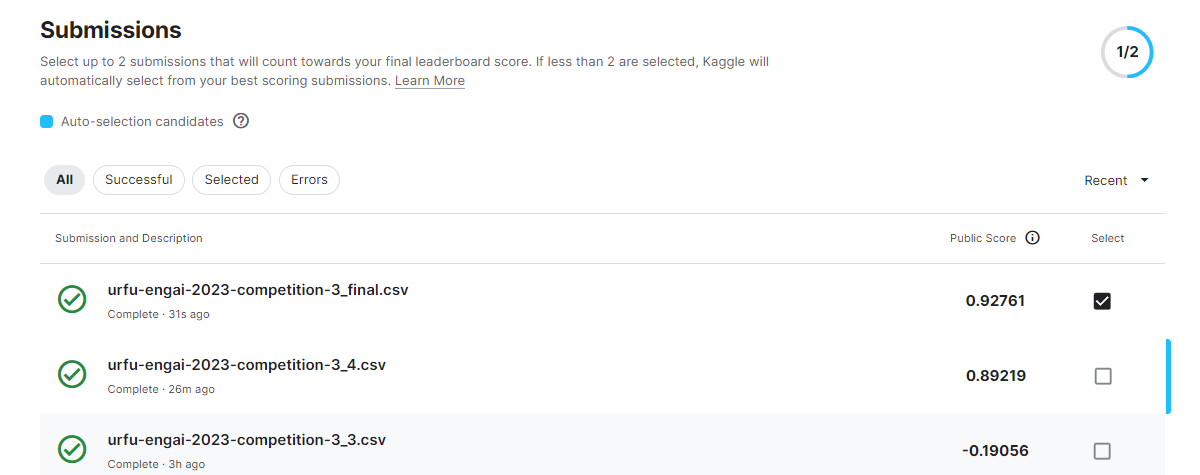

In [73]:
Image("3sem_reg_1.png", width=620, height=480) 

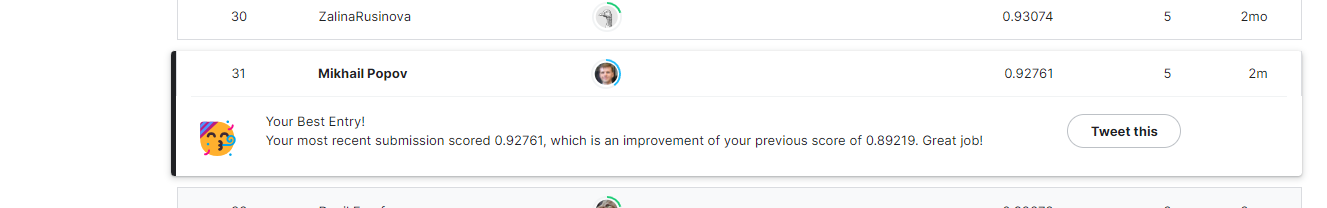

In [74]:
Image("3sem_reg_2.png", width=620, height=480) 